In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

In [17]:
file_names= 'arabidopsis_selected_tissues'
location = f'../../../data/output/{file_names}'
promoter_pref='promoters_5UTR'
#file_names='non-overlapping_includingbidirectional_all_genes_newannotation'

Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw/{promoter_pref}_GCcontent_rw.tsv'
EPD_TSS_bed = f'../../../data/EPD_promoter_analysis/EPDnew_promoters/At_EPDnew.bed'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'
promoter_no_5UTR = f'{location}/promoters.gff3'
foldername_prefix = 'OpenChromatin_rw'

In [18]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_rootshootintersect_bpcovered_rw.bed'

In [19]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/OpenChromatin_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/arabidopsis_selected_tissues/rolling_window/OpenChromatin_rw/plots  created


In [20]:
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
#read in GC content table just to get the window locations (GC content not wanted, just open chromatin)
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
GC_content
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])
#make df columns integars
GC_content = GC_content.astype({'stop':'int','start':'int','chr':'int'})
#add window length column
GC_content = GC_content.assign(window_length=GC_content.stop - GC_content.start)

#merge to limit to genes of interest
GC_content = pd.merge(promoters, GC_content, how ='left', on='AGI')
GC_content

,AGI,gene_type,name,percentage_GC_content,window_number,chr,start,stop,window_length
0,AT5G52710,constitutive,AT5G52710_19::5:21374752-21374852,30.0,19,5,21374752,21374852,100
1,AT5G52710,constitutive,AT5G52710_18::5:21374802-21374902,31.0,18,5,21374802,21374902,100
2,AT5G52710,constitutive,AT5G52710_17::5:21374852-21374952,29.0,17,5,21374852,21374952,100
3,AT5G52710,constitutive,AT5G52710_16::5:21374902-21375002,42.0,16,5,21374902,21375002,100
4,AT5G52710,constitutive,AT5G52710_15::5:21374952-21375052,44.0,15,5,21374952,21375052,100
...,...,...,...,...,...,...,...,...,...
5930,AT3G57240,control,AT3G57240_16::3:21183795-21183895,31.0,16,3,21183795,21183895,100
5931,AT3G57240,control,AT3G57240_17::3:21183845-21183945,29.0,17,3,21183845,21183945,100
5932,AT3G57240,control,AT3G57240_18::3:21183895-21183995,20.0,18,3,21183895,21183995,100
5933,AT3G57240,control,AT3G57240_19::3:21183945-21184045,28.0,19,3,21183945,21184045,100


In [21]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("ticks")

In [22]:
# dist_plot = GC_content['percentage_GC_content']
# #create figure with no transparency
# dist_plot_fig = sns.distplot(dist_plot).get_figure()

In [23]:
#remove windows with fewer than 100 promoters extending to that location
GC_content = GC_content[GC_content['window_number'].map(GC_content['window_number'].value_counts()) > 99]

In [24]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [25]:
def rep_sample(df, col, n, random_state):
    """function to return a df with equal sample sizes
    taken from here: https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe"""
    #identify number of categories
    nu = df[col].nunique()
    # find number of rows
    m = len(df)
    # integar divide total sample size by number of categories
    mpb = n // nu
    # multiply this by the number of categories and subtract from the number of samples to find the remainder
    mku = n - mpb * nu
    # make an array fileld with zeros corresponding to each category
    fills = np.zeros(nu)

    # make values in the array 1s up until the remainder
    fills[:mku] = 1

    # calculate sample sizes for each category
    sample_sizes = (np.ones(nu) * mpb + fills).astype(int)

    #group the df by categories
    gb = df.groupby(col)
    #define sample size function
    sample = lambda sub_df, i: sub_df.sample(sample_sizes[i], random_state = random_state)
    #run sample size function on each category
    subs = [sample(sub_df, i) for i, (_, sub_df) in enumerate(gb)]
    #return concatenated sub dfs
    return pd.concat(subs)

In [26]:
def windows_coords(output_prefix,variable_of_interest_name,variable_of_interest_df,promoter_bed,promoter_no_5UTR,
                   window_offset,EPD_TSS_bed,includeEPDTSS=False,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='median',ci=95, n_boot=10000, 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot. Also add promoter length distribution, Araport TSS distribution,
    EPD TSS distribution (add the most common TSS as documented on eukaryotic promoter database Arabidopsis last modified on EPD 06/06/2018)"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start  
    #merge promoter_bed with variable_of_interest_df on AGI
    merged = pd.merge(variable_of_interest_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    #remove NaN
    merged = merged[merged['percentage_GC_content'].notnull()]
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #get longest transcript TSS distribution (if Araport 11 definition used)
    promoter_no_5UTR_df = pd.read_table(promoter_no_5UTR, sep='\t', header=None)
    col = ['chr', 'source', 'type', 'start','stop', 'dot1','strand','dot2','attributes']
    promoter_no_5UTR_df.columns = col
    #add AGI column
    promoter_no_5UTR_df_agi = promoter_no_5UTR_df.assign(AGI=promoter_no_5UTR_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    #merged with windows    
    merged2 = pd.merge(merged2,promoter_no_5UTR_df_agi, on='AGI', how='left', suffixes=('','_no_UTR'))
    #remove NaN (promoters in promoters.gff but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]
    #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
    merged2 = merged2[merged2.chr_no_UTR.notnull()]
    #Get most common transcript TSS location from eukaryotic promoter database (last modified on EPD 06/06/2018)
    #Note - not all promoters have a TSS on EPD
#     if includeEPDTSS==True:
#         EPD_TSS_df = pd.read_table(EPD_TSS_bed, delim_whitespace=True, header=None, skiprows=4)
#         cols = ['chr','start','stop','transcript_EPD','score_EPD','strand_EPD','thickstart_EPD','thickend_EPD']
#         EPD_TSS_df.columns = cols
#         #add AGI column
#         EPD_TSS_df['AGI'] = EPD_TSS_df.transcript_EPD.str.split('_',expand=True)[0]
#         #add TSS location column
#         EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'thickstart_EPD']
#         EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'thickend_EPD'] -1
#         #merged with windows
#         merged2 = pd.merge(merged2,EPD_TSS_df, on='AGI', how='left', suffixes=('','_EPD'))

#         #remove NaN (promoters in EPD but not in promoters_5UTR)
#         merged2 = merged2[merged2.length.notnull()]
#         #transfrom EPD TSS column in the same way as the position column
#         merged2.loc[merged2.strand == '-', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '-', 'TSS_EPD'] - merged2.loc[merged2.strand == '-','start_wholeprom']
#         merged2.loc[merged2.strand == '+', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS_EPD']
#         #make integars
#         merged2 = merged2.astype({'TSS_transformed_EPD':'float64'})
    
    #calculate longest promoter length based on window cutoff
    number_of_windows = len(variable_of_interest_df.window_number.unique())
    window_length = variable_of_interest_df.window_length.max()    
    length_of_longest_promoter = number_of_windows*(window_length-window_offset)

    #make 0 start like in bed files
    merged2.start_no_UTR = merged2.start_no_UTR -1
    #add Araport TSS location column
    #merged2['TSS'] = int()
    merged2.loc[merged2.strand == '+', 'TSS'] = merged2.loc[merged2.strand == '+', 'stop_no_UTR']
    merged2.loc[merged2.strand == '-', 'TSS'] = merged2.loc[merged2.strand == '-', 'start_no_UTR'] -1
    #transform TSS location in the same way as the position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '-', 'TSS'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS']

    #make integars
    merged2 = merged2.astype({'start_no_UTR':'float64','stop_no_UTR':'float64','TSS':'float64','TSS_transformed_Araport11':'float64',f'{chromatin_tissue_variable}':'float64'})
    #return merged2[['AGI','strand','start','stop','start_wholeprom','stop_wholeprom','start_no_UTR','stop_no_UTR','TSS','TSS_transformed','position','chr_no_UTR','window_number']]


        
    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 2
    
    #make subplots
#     if includeEPDTSS == True:
#         subplots = subplots + 1
#         f, axes = plt.subplots(subplots, figsize=(10,10))
#         OpenChromplot = axes[subplots-subplots]
#         Araport11TSSplot = axes[subplots-(subplots-1)]
#         EPDTSSplot = axes[subplots-(subplots-2)]   
#         #promlengthsplot = axes[subplots-(subplots-3)]
#         variableofinterestplot = axes[subplots-(subplots-3)]
#     else:
#         f, axes = plt.subplots(subplots, figsize=(10,8))
#         OpenChromplot = axes[subplots-subplots]
#         Araport11TSSplot = axes[subplots-(subplots-1)]
#         #promlengthsplot = axes[subplots-(subplots-2)]
#         variableofinterestplot = axes[subplots-(subplots-2)]

#     if includeEPDTSS == True:
#         subplots = subplots + 1
#         f, axes = plt.subplots(subplots, figsize=(10,8))
#         OpenChromplot = axes[subplots-subplots]
#         #Araport11TSSplot = axes[subplots-(subplots-1)]
#         EPDTSSplot = axes[subplots-(subplots-1)]   
#         #promlengthsplot = axes[subplots-(subplots-3)]
#         variableofinterestplot = axes[subplots-(subplots-2)]
#     else:
#         f, axes = plt.subplots(subplots, figsize=(10,6))
#         OpenChromplot = axes[subplots-subplots]
#         #Araport11TSSplot = axes[subplots-(subplots-1)]
#         #promlengthsplot = axes[subplots-(subplots-2)]
#         variableofinterestplot = axes[subplots-(subplots-1)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None
    try:
        Araport11TSSplot
    except NameError:
        Araport11TSSplot = None
    try:
        EPDTSSplot
    except NameError:
        EPDTSSplot = None
#     try:
#         promlengthsplot
#     except NameError:
#         promlengthsplot = None
    try:
        variableofinterestplot
    except NameError:
        variableofinterestplot = None
    
    #If EPD TSS plot is present, filter promoters which aren't in EPD to remove NaNs
    if EPDTSSplot != None:
        #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
        merged2 = merged2[merged2.TSS_transformed_EPD.notnull()]
    
    if genetype!=False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #remove windows with fewer than 50 promoters extending to that location if looking at specific genetypes
        merged2 = merged2[merged2['window_number'].map(merged2['window_number'].value_counts()) > 49]
        #redefine longest promoter length based on window cutoff
        number_of_windows = len(merged2.window_number.unique())
        window_length = merged2.window_length.max()    
        length_of_longest_promoter = number_of_windows*(window_length-window_offset)
        
    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    if includeEPDTSS==True:
        merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']] = -merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']]
    else:
        merged2[['length','TSS_transformed_Araport11','position']] = -merged2[['length','TSS_transformed_Araport11','position']]

    if genetype==False:
        
        #length_of_longest_promoter = merged_positive.length.max()
        #if openchromplot variable present, add that plot
        #next plot letter name


        #Open chromatin lineplot
        plot = sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,estimator=new_estimator,ci=ci, n_boot=n_boot).get_figure()
        #set titles and axes labels
        #OpenChromplot.set_title(f'All promoters {chromatin_tissue_variable_name}', weight='bold')
        plt.ylabel(f'{estimator} % open chromatin')
        plt.xlabel('position upstream of ATG')
           
               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
      
          
        #Open chromatin lineplot
        sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                     estimator=new_estimator,ci=ci, n_boot=n_boot).get_figure()
        #set titles and axes labels
        #plt.set_title(f'{nextletter}: {genetype} {chromatin_tissue_variable_name}', weight='bold')
        plt.ylabel(f'{estimator} % open chromatin')
        plt.xlabel('position upstream of ATG')
          
            
        
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #variableofinterestplot.set_ylim([0,merged2.groupby('window_number')[variable_of_interest].median().max()+20])
        #set x axis range if specified 
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range
        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])        
#         f.tight_layout()
        
    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal
        # first select only the relevant genetypes
        merged2 = merged2[merged2.gene_type.isin([genetype,genetype2])]
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
                   
        #Open chromatin lineplot
        sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                     estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot).get_figure()
        sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                     estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
        #set titles & axes names
        #plt.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
        plt.ylabel(f'{estimator} % open chromatin')
        plt.xlabel('position upstream of ATG')           

        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        plt.legend()

#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#         f.tight_layout()
    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        
        ## make a subselection of categories so all sample sizes are equal    
        # make each promoter unique
        merged2_unique = merged2.drop_duplicates('AGI')
        # identify sample size of the minimum category
        minimum_sample_size = merged2_unique.gene_type.value_counts().min()
        # print this
        print(f'sample size in each category = {minimum_sample_size}')
        # multiply this by the number of categories
        total_sample_size = minimum_sample_size * len(merged2_unique.gene_type.unique())
        #select equal sample sizes of each category with a random state of 1 so it's reproducible
        equal_samplesizes = rep_sample(merged2_unique, 'gene_type',total_sample_size,random_state = 1)
        # now filter out genes which were not selected using the minimum sample size
        to_remove = merged2_unique[~merged2_unique.AGI.isin(equal_samplesizes.AGI)]
        merged2 = merged2[~merged2.AGI.isin(to_remove.AGI)]
        
        
        
        
    
                    
        #Open chromatin lineplot
        sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,
                     estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot).get_figure()
        sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,
                     estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
        sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,ax=OpenChromplot,
                     estimator=new_estimator,label=genetype3,ci=ci, n_boot=n_boot)
            #set titles & axes names 
           # plt.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
        plt.ylabel(f'{estimator} % open chromatin')
        plt.xlabel('position upstream of ATG')           
      
     
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        plt.legend()
        #set x axis length
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#             leg = n.legend()
#         f.tight_layout()
    #set x axis range if specified    
    if x_range==False:
        pass
    else:
        length_of_longest_promoter = x_range
        
    #for all subplots:
    #remove grids
    plt.grid(False)
    #plt.set_xlim([(-length_of_longest_promoter-50),0])
    #set a tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}/plots/{output_prefix}_{chromatin_tissue_variable}_{estimator}_sliding_window.pdf', format='pdf')    
    return merged2

In [27]:
def plot_length(df,output_prefix, genetype=False, genetype2=False, genetype3=False):
    """function to plot length distribution of promoter"""
    #make lengths positive by squaring and then square rooting
    df.length = (df.length**2)**(1/2)
    
    if genetype==False:
        dist_plot = df['length']
        #create figure with no transparency
        dist_plot_fig = sns.distplot(dist_plot,axlabel='length (bp)').get_figure()

    elif genetype2==False:
        sns.distplot(df[df.gene_type == genetype].length, label=genetype,axlabel='length (bp)')
        
    elif genetype3==False:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2,axlabel='length (bp)').get_figure()
        plt.legend()
    else:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].length,hist=None,label=genetype3,axlabel='length (bp)')
       # plt.axlabel='length (bp)'
        plt.legend()
    #tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}/plots/{output_prefix}_promoter_lengths.pdf', format='pdf')
        

In [28]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""

    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [29]:
#add root chromatin coverage data
openchrom = add_coverage(GC_content, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
openchrom = add_coverage(openchrom, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
openchrom = add_coverage(openchrom, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

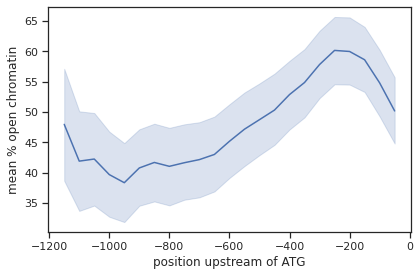

In [30]:
#all promoters in genome
all_proms = windows_coords('all_proms','% open chromatin',openchrom,promoter_bed,promoter_no_5UTR,50,EPD_TSS_bed,estimator='mean')

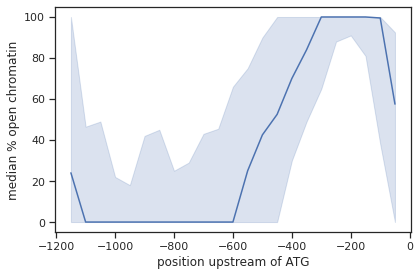

In [31]:
#all promoters in genome
all_proms = windows_coords('all_proms','% GC content',openchrom,promoter_bed,promoter_no_5UTR,50,EPD_TSS_bed,estimator='median')

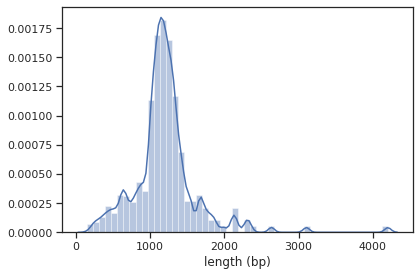

In [32]:
plot_length(all_proms,'allproms', genetype=False)

## Now do constitutive and variable promoter from Czechowski et al 2005

In [33]:
openchrom_prom_types = add_genetype(openchrom, Czechowski_gene_categories)

In [34]:
#rename genetype column
if 'gene_type_x' in openchrom_prom_types.columns:
    openchrom_prom_types.rename(columns={"gene_type_x": "gene_type"},inplace=True)
    

sample size in each category = 100


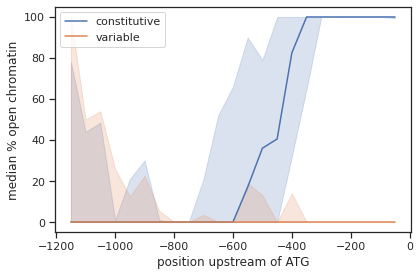

In [35]:
rolling_rootshootintersect = windows_coords('Czechowski_genetypenocontrol','% open chromatin',openchrom_prom_types,promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed,includeEPDTSS=False,x_range=1350,estimator='median',  genetype='constitutive', genetype2='variable',ci=95, n_boot=10000)

In [36]:
# const = rolling_rootshootintersect[rolling_rootshootintersect.gene_type == 'constitutive']
# const[const.position >=-400].median()

sample size in each category = 100


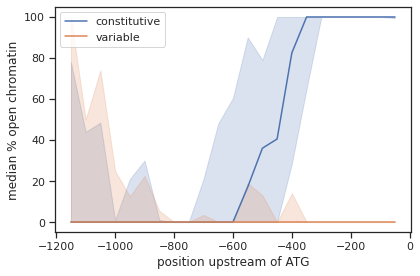

In [37]:
rolling_rootshootintersect = windows_coords('Czechowski_genetypenocontrol','% open chromatin',openchrom_prom_types,promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed,includeEPDTSS=False,estimator='median',  genetype='constitutive', genetype2='variable',ci=95, n_boot=10000)

In [38]:
# openchrom_prom_types_length = add_genetype(all_proms, Czechowski_gene_categories)

In [39]:
# plot_length(openchrom_prom_types_length,'Czechowski_genetypenocontrol', genetype='constitutive', genetype2='variable')

sample size in each category = 100


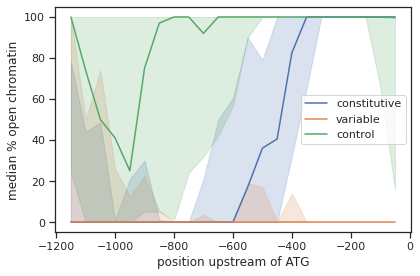

In [40]:
rolling_incl_control = windows_coords('Czechowski_genetype','% open chromatin',openchrom_prom_types,
                                      promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,includeEPDTSS=False,estimator='median',x_range=1350,
                                      genetype='constitutive', genetype2='variable', genetype3='control')

In [41]:
# plot_length(openchrom_prom_types_length,'Czechowski_genetype', genetype='constitutive', genetype2='variable', genetype3='control')